# Correlations between $\Delta Z$ and other galaxy properties

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import sys
sys.path.append('../../src')
from multiclass import *

import torch 

from IPython.display import display

PATH = os.path.abspath('../..')

# Get test set data

In [2]:
df_full = pd.read_csv(f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv', index_col=0)

df_pred = pd.read_csv(f'{PATH}/catalogs/predictions_128-oh_p50.csv', index_col=0)
test_idx = df_pred.index

df_test = df_full.loc[test_idx]

In [3]:
df_test.columns

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p2p5', 'oh_p16', 'oh_p50',
       'oh_p84', 'oh_p97p5', 'lgm_tot_p50', 'sfr_tot_p50'],
      dtype='object')

In [4]:
df_test.sample(5)

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,d4000,d4000_err,bptclass,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50
objID,,,,,,,,,,,,,,,,,,,,,
1237651539259687048,692448548171573248,234.798180,57.708064,0.107494,0.000014,122.04620,18.859780,20.35906,0.091667,18.64546,...,1.703016,0.051350,1,8.821954,8.863633,8.913849,8.959753,8.998327,10.583950,0.208984
1237651272963588139,543940254290176000,134.889738,57.341891,0.039970,0.000010,66.11660,8.139254,17.72781,0.018204,16.89548,...,1.413923,0.013742,1,9.040488,9.043196,9.050015,9.056836,9.059544,10.100760,-0.078881
1237661816025514156,1909530692329433088,197.511209,11.451901,0.054171,0.000015,105.85930,10.913560,17.19557,0.018215,15.83392,...,1.572394,0.028130,1,8.984159,9.037470,9.106412,9.184558,9.295628,10.586420,0.509633
1237651752396718264,576463809380640768,173.124607,1.290541,0.141026,0.000008,72.36713,16.512840,19.71452,0.072139,18.13368,...,1.288904,0.018368,1,8.738543,8.801408,8.845988,8.877656,8.938636,10.230160,0.504696
1237665567684034702,2413953103020713984,222.607317,21.374742,0.061034,0.000010,100.78930,24.401190,19.01030,0.048472,17.69500,...,1.593852,0.032925,1,8.783379,8.821316,8.854304,8.879352,8.938758,9.847943,-0.045630


In [5]:
len(df_pred)

20466

Note that one of the indices is duplicated for some reason...

In [6]:
df_test = df_test[~df_test.index.duplicated(keep='first')]

In [7]:
len(df_test)

20466

In [8]:
df = df_pred.join(df_test.drop('oh_p50', axis='columns'), how='left')

In [9]:
df.head()

,oh_p50,prediction,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,...,h_delta_flux_err,d4000,d4000_err,bptclass,oh_p2p5,oh_p16,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50
objID,,,,,,,,,,,,,,,,,,,,,
1237658493878337647,8.577997,8.696861,1392840760562313216,153.065673,9.393589,0.052860,0.000010,0.00000,100.59110,19.24347,...,2.961265,1.393617,0.034535,1,8.164732,8.378000,8.680438,8.748820,9.410803,-0.398485
1237665330918850673,8.726439,8.757436,2240661544268490752,165.432551,31.554196,0.034537,0.000007,42.24826,12.03756,17.99890,...,2.273183,1.403976,0.014674,1,8.653717,8.701375,8.756987,8.824885,9.542205,-0.178529
1237657630582178125,8.948060,9.024221,928874883251726336,123.488570,33.123225,0.111484,0.000007,99.12975,21.82991,18.67058,...,2.548263,1.306892,0.015236,1,8.899887,8.938868,8.956317,8.959596,10.287520,0.875822
1237651250411405534,8.894798,9.015285,501053527515228160,130.248831,50.149482,0.156886,0.000017,162.45530,15.42012,20.12226,...,2.300682,1.675999,0.027175,1,8.725135,8.819554,8.962484,9.010794,10.776900,0.403948
1237674651536261211,8.333275,8.544479,317593961499748352,173.030116,0.910884,0.029602,0.000011,51.42912,33.51934,19.09125,...,2.219449,1.621131,0.065915,1,8.077692,8.181426,8.494060,8.608570,8.885455,-0.606143


In [10]:
df['dZ'] = df.prediction - df.oh_p50

# Check for correlations

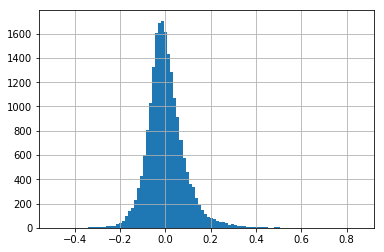

In [11]:
df.dZ.hist(bins=100)

In [13]:
rmse_np(df.prediction, df.oh_p50)

0.08511842951594693

## Magnitudes (fluxes)

### $r$ magnitude

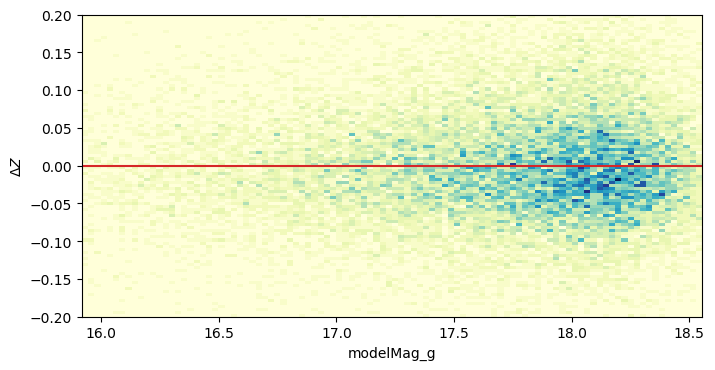

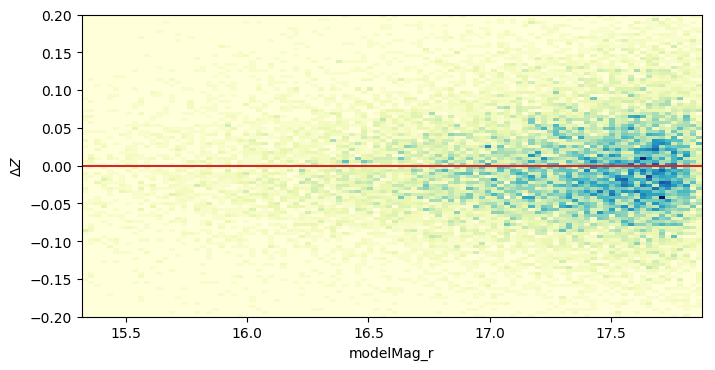

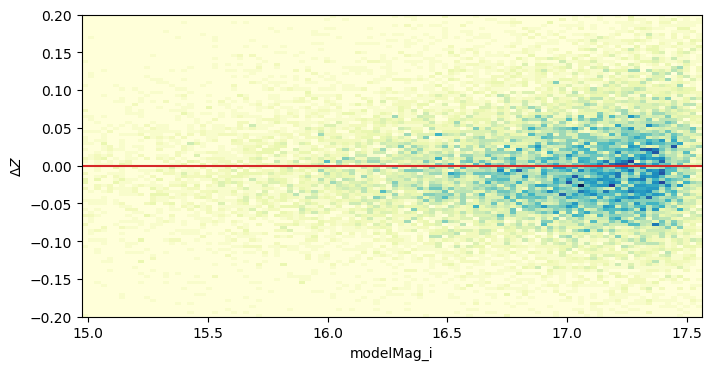

In [63]:
for mag in ['modelMag_g', 'modelMag_r', 'modelMag_i']:
    plt.figure(figsize=(8, 4), dpi=100)
    plt.hist2d(x=mag, y='dZ', data=df, range=[np.percentile(df[mag], [2.5, 97.5]), [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
    plt.ylabel(r'$\Delta Z$')
    plt.xlabel(mag)
    plt.axhline(0, color='C3')
    plt.show()

## Colors

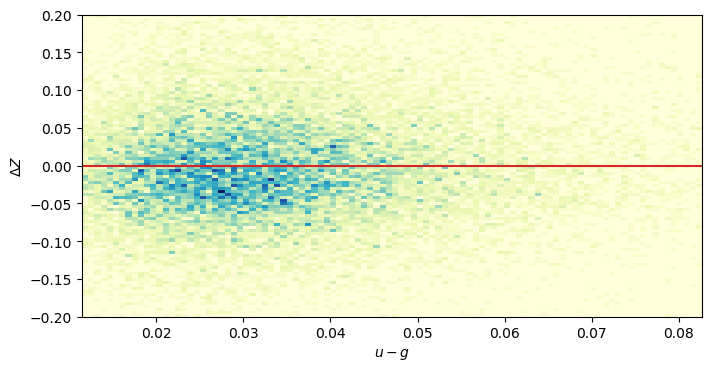

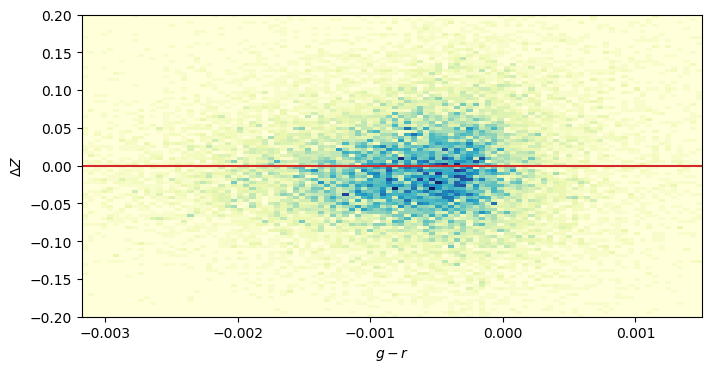

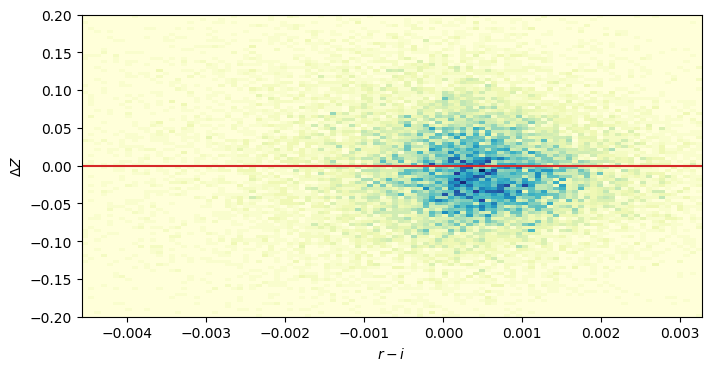

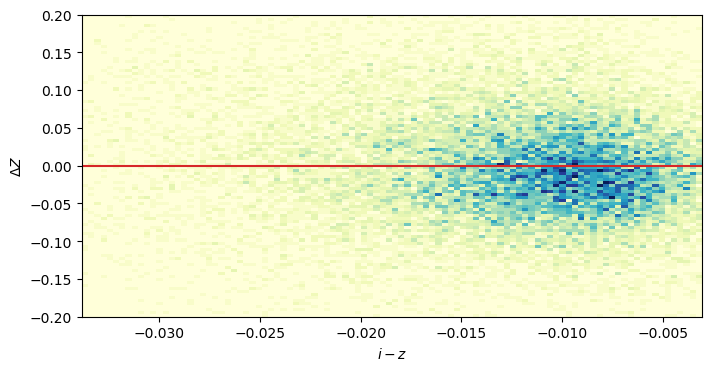

In [64]:
y = df.dZ
colors = ['$u-g$', '$g-r$', '$r-i$', '$i-z$']

for x, color in zip([df.modelMagErr_u - df.modelMagErr_r,
              df.modelMagErr_r - df.modelMagErr_g,
              df.modelMagErr_g - df.modelMagErr_i,
              df.modelMagErr_i - df.modelMagErr_z],
             colors):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.hist2d(x=x, y=y, range=[np.percentile(x, [2.5, 97.5]), [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
    plt.axhline(0, color='C3')
    plt.xlabel(color)
    plt.ylabel(r'$\Delta Z$')
    plt.show()

## Redshift

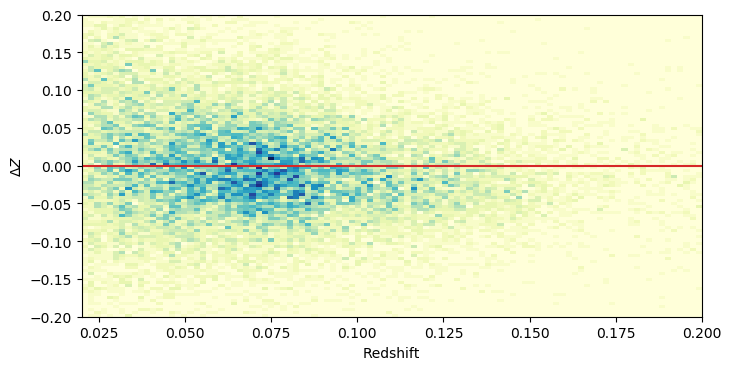

In [73]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(x='z', y='dZ', data=df, range=[[0.02, 0.2], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel('Redshift')
plt.ylabel(r'$\Delta Z$')
plt.show()

## Emission line SNR

### H$\alpha$

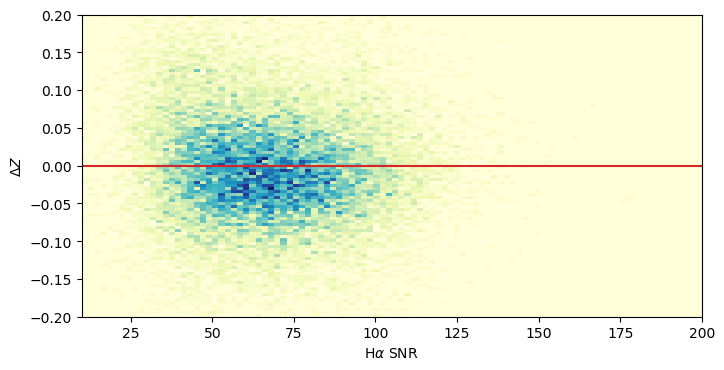

In [74]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.h_alpha_flux / df.h_alpha_flux_err, y=df.dZ, data=df, range=[[10, 200], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'H$\alpha$ SNR')
plt.ylabel(r'$\Delta Z$')
plt.show()

### [O III]

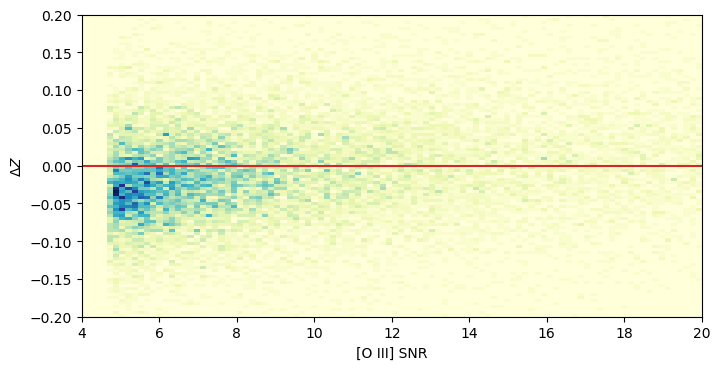

In [80]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.oiii_5007_flux / df.oiii_5007_flux_err, y=df.dZ, data=df, range=[[4, 20], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'[O III] SNR')
plt.ylabel(r'$\Delta Z$')
plt.show()

### H$\beta$

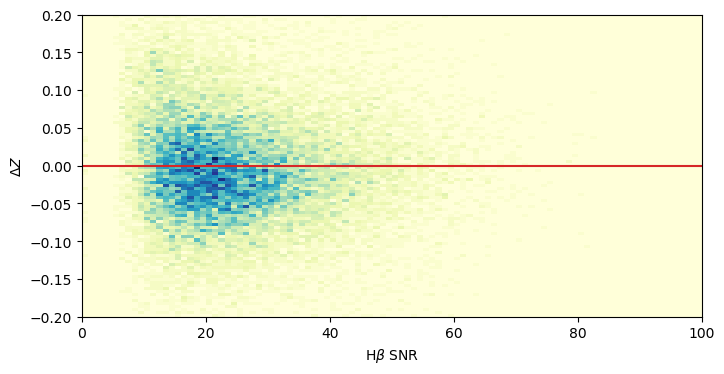

In [82]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.h_beta_flux / df.h_beta_flux_err, y=df.dZ, data=df, range=[[0, 100], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'H$\beta$ SNR')
plt.ylabel(r'$\Delta Z$')
plt.show()

### [N II]

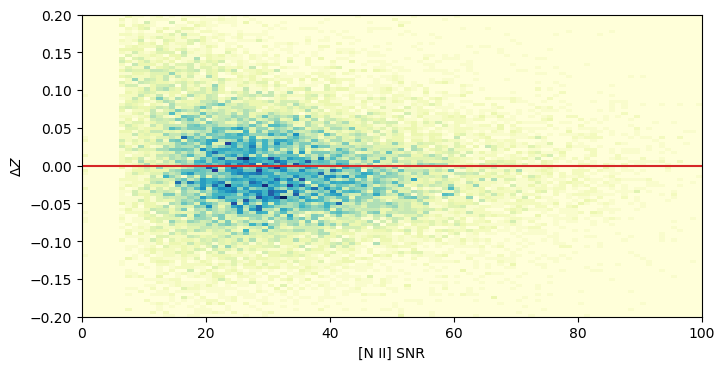

In [83]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.nii_6584_flux / df.nii_6584_flux_err, y=df.dZ, data=df, range=[[0, 100], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'[N II] SNR')
plt.ylabel(r'$\Delta Z$')
plt.show()

## Other properties

### Stellar mass

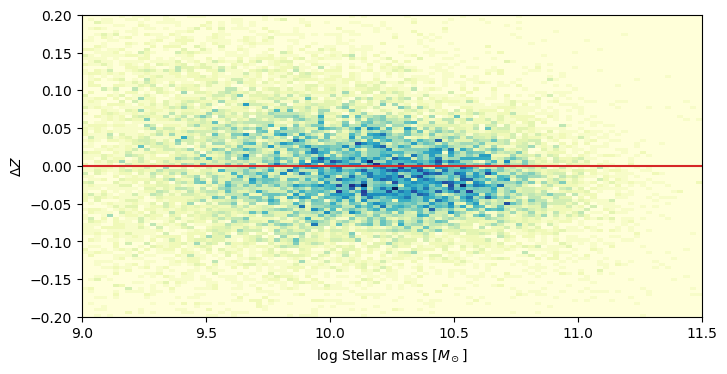

In [86]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.lgm_tot_p50, y=df.dZ, data=df, range=[[9, 11.5], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'log Stellar mass [$M_\odot$]')
plt.ylabel(r'$\Delta Z$')
plt.show()

### SFR

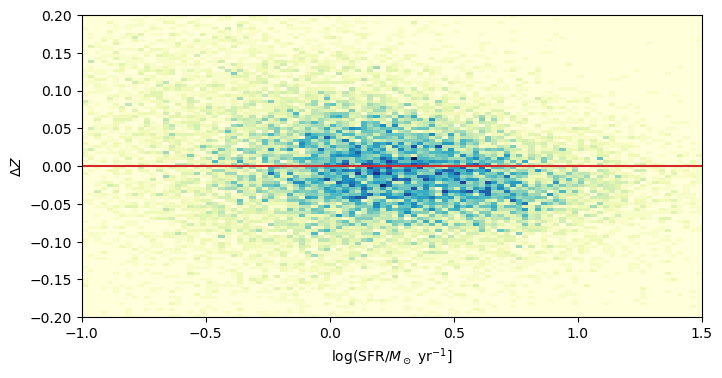

In [91]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.sfr_tot_p50, y=df.dZ, data=df, range=[[-1, 1.5], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'log(SFR/$M_\odot$ yr$^{-1}$]')
plt.ylabel(r'$\Delta Z$')
plt.show()

## Spread in metallicity

### 68 percent credible interval

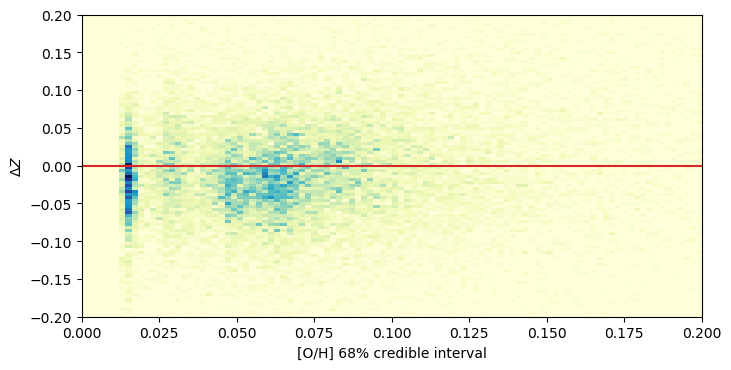

In [92]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.oh_p84 - df.oh_p16, y=df.dZ, data=df, range=[[0, 0.2], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'[O/H] 68% credible interval')
plt.ylabel(r'$\Delta Z$')
plt.show()

### 95 percent credible interval

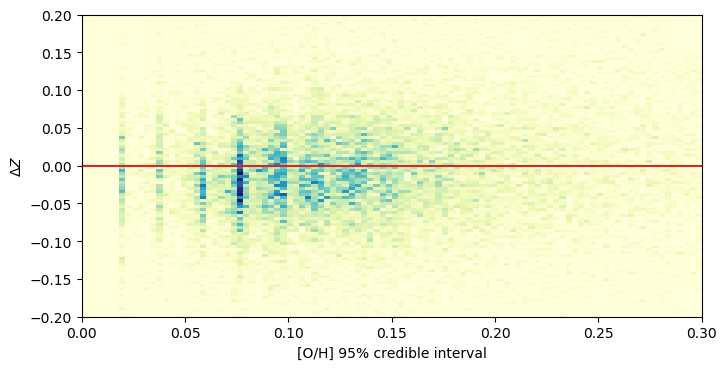

In [94]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.oh_p97p5 - df.oh_p2p5, y=df.dZ, data=df, range=[[0, 0.3], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'[O/H] 95% credible interval')
plt.ylabel(r'$\Delta Z$')
plt.show()

### 50th percentile (aka what we are predicting)

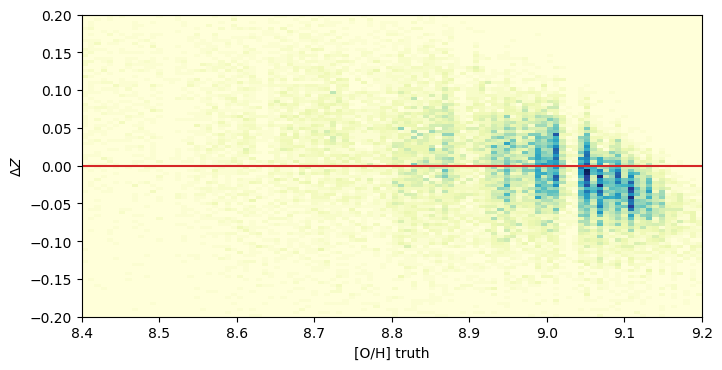

In [97]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist2d(df.oh_p50, y=df.dZ, data=df, range=[[8.4, 9.2], [-0.2, 0.2]], bins=(100, 100), cmap='YlGnBu')
plt.axhline(0, color='C3')
plt.xlabel(r'[O/H] truth')
plt.ylabel(r'$\Delta Z$')
plt.show()